In [1]:
# To turn images into animation, modify this command:
#   ffmpeg -f image2 -framerate 2 -i %06d.jpg -s 512x512 ../test.avi

using Images
using PyPlot
using FileIO
using ImageView

# testfile = "boat"
testfile = "lena"
# testfile = "mandrill"
# testfile = "peppers"
# testfile = "sanfran"

img = load(string("testimages/",testfile,".pnm"))
f = real(img) # julia colour space is 0 "black, 1 "white"
fimg0 = colorview(Gray,f) #display image

INFO: Precompiling module ImageView.
ERROR: LoadError: error compiling anonymous: could not load library "libgtk-3"
dlopen(libgtk-3.dylib, 1): image not found
 in include_from_node1(::String) at ./loading.jl:488
 in include_from_node1(::String) at /Applications/Julia-0.5.app/Contents/Resources/julia/lib/julia/sys.dylib:?
 in macro expansion; at ./none:2 [inlined]
 in anonymous at ./<missing>:?
 in eval(::Module, ::Any) at ./boot.jl:234
 in eval(::Module, ::Any) at /Applications/Julia-0.5.app/Contents/Resources/julia/lib/julia/sys.dylib:?
 in process_options(::Base.JLOptions) at ./client.jl:242
 in _start() at ./client.jl:321
 in _start() at /Applications/Julia-0.5.app/Contents/Resources/julia/lib/julia/sys.dylib:?
while loading /Users/martinpham/.julia/v0.5/Gtk/src/Gtk.jl, in expression starting on line 37
ERROR: LoadError: Failed to precompile Gtk to /Users/martinpham/.julia/lib/v0.5/Gtk.ji.
 in compilecache(::String) at ./loading.jl:593
 in require(::Symbol) at ./loading.jl:393
 in r

LoadError: Failed to precompile ImageView to /Users/martinpham/.julia/lib/v0.5/ImageView.ji.

In [2]:
# Affine transformations on domain blocks:
#   4 rotations (0, 90, 180, 270), 4 flips (x,y,diagonals)
function transformdblock(D,k)
    if 1 <= k <= 4
        D = rotl90(D,k-1)
    else
        if k == 5 #flip along y axis
            D = D[1:end, end:-1:1]
        elseif k == 6 # flip along x axis
            D = D[end:-1:1, 1:end]
        elseif k == 7 # flip along bottomleft-topright axis
            D = rot180(D)'
        else # flip along topleft-bottomright axis
            D = D'
        end
    end
    return D
end

# Sub-sample 16x16 dblock into 8x8 for scaling to range block
function decdblock(dblock)
    Dj = zeros(8,8)
    for i = 1:8
        y = 2(i-1)+1
        for j = 1:8
            x = 2(j-1)+1
            Dj[i,j] = mean(dblock[y:y+1,x:x+1])
        end
    end
    return Dj
end

# Get array of 8x8 range blocks from image
# Also returns numy,numx the number of blocks in each direction
# so that we can reconstruct from the array by raster
function rangeblocks(f)
    s = size(f) #expect 512,512.. partition into 8x8 blocks
    numy = s[1]/8
    numx = s[2]/8
    R = []
    for y = 1:numy
        yspan = Int(1+8(y-1))
        yspan = yspan:yspan+7
        for x = 1:numx
            xspan = Int(1+8(x-1))
            xspan = xspan:xspan+7
            rblock = f[yspan,xspan]
            push!(R,rblock)
        end
    end
    return R,numy,numx
end

# Get array of decimated 8x8 domain blocks from image
function domainblocks(f)
    s = size(f)
    numy = s[1]/16
    numx = s[2]/16
    D = []
    for y = 1:numy
        yspan = Int(1+16(y-1))
        yspan = yspan:yspan+15
        for x = 1:numx
            xspan = Int(1+16(x-1))
            xspan = xspan:xspan+15
            dblock = f[yspan,xspan]
            Dj = decdblock(dblock)
            push!(D,Dj)
        end
    end
    return D
end

# Optimize over affine greyscale parameters by imposing stationary 
# condition on RSME wrt alpha,beta
function greyscaleaffine(Ri,Dj)
    A = zeros(2,2)
    A[1,1] = sum(Dj.*Dj)
    A[1,2] = A[2,1] = sum(Dj)
    A[2,2] = length(Dj)
    B = zeros(2,1)
    B[1] = sum(Ri.*Dj)
    B[2] = sum(Ri)
    alpha,beta = A\B
    return alpha,beta
end

# Encodes image array into local-IFS parameters
#   alpha,beta found by imposing stationary condition on RMS E term
# Input: square 512*512 image array
# Output:
#   encode: array of Ri block information (parent block j, alpha, beta)
#   numy: number of range blocks in y direction
#   numx: number of range blocks in x direction
function encoder(f)
    tic()
    R,numy,numx = rangeblocks(f)
    D = domainblocks(f)
    encode = [] # array to store info for each range block
    for i = 1:length(R)
        Ri = R[i]
        besterr = 1e2
        bestj,bestalpha,bestbeta,bestk = (1,0,0,1)
        for j = 1:length(D)
            Dj = D[j] 
            for k = 1:8
                Djk = transformdblock(Dj,k)
                alpha,beta = greyscaleaffine(Ri,Djk)
                err = Ri - alpha*Djk - beta
                err = sqrt(sum(err.^2)/length(err))
                if err < besterr
                    besterr = err
                    bestj,bestalpha,bestbeta,bestk = (j,alpha,beta,k)
                end
            end
        end 
        push!(encode,(i,bestj,bestalpha,bestbeta,bestk))
    end
    toc()
    return encode,numy,numx
end



encoder (generic function with 1 method)

In [3]:
# Get 16x16 domain block from image g at index j given number of blocks in x direction
function dblock(g,j,numx)
    yspan = Int(16div(j-1,0.5numx)+1)
    yspan = yspan:yspan+15
    xspan = Int(16mod(j-1,0.5numx)+1)
    xspan = xspan:xspan+15
    dblock = g[yspan,xspan]
    Dj = decdblock(dblock)
    return Dj
end

# Given fractal transform T (encdata) returns (g,f) where g = Tf
function fractaltransform(f, encdata)
    encoded,numy,numx = encdata
    g = zeros(size(f))
    for i = 1:length(encoded)
        (i,j,alpha,beta,k) = encoded[i]
        Dj = dblock(f,j,numx)
        Djk = transformdblock(Dj,k)
        yspan = Int(8*div(i-1,numx)+1)
        yspan = yspan:yspan+7
        xspan = Int(8*mod(i-1,numx)+1)
        xspan = xspan:xspan+7
        g[yspan,xspan] = alpha*Djk + beta
    end
    return g,f
end

# Decodes range block information (best parent j, alpha, beta) given number
# of blocks in both directions
function decoder(encdata)
    tic()
    encoded,numy,numx = encdata
    f = rand(Int(numy*8),Int(numx*8))
    tol = 1e-10
    err = 1
    t = 0
    Tend = 100
    while (err > tol) & (t <= Tend)
        t = t+1
        f,g = fractaltransform(f, encdata)
        err = f-g
        err = sqrt(sum(err.^2)/length(err))
        tlabel = lpad(string(t),6,"0")
        save("temp/compression/$tlabel.jpg", map(clamp01nan, colorview(Gray,g)))
    end
    toc()
    println(t)
    return f
end

decoder (generic function with 1 method)

In [4]:
# Encode image
# boat: 173 seconds
# lena: 184
# mandrill: 171
# peppers: 163
# sanfran: 167
encodedimg = encoder(f)

elapsed time: 181.201664613 seconds


(Any[(1,896,0.38034,0.619704,2),(2,896,0.376245,0.623734,2),(3,800,0.370767,0.629242,7),(4,864,0.363582,0.636391,2),(5,896,0.365171,0.634795,7),(6,864,0.364812,0.635181,7),(7,864,0.366488,0.63352,2),(8,832,0.361078,0.638919,2),(9,832,0.36213,0.637865,7),(10,896,0.370213,0.629849,7)  …  (4087,536,0.226631,0.508389,6),(4088,745,0.303031,0.420352,7),(4089,264,0.373229,0.364807,2),(4090,711,-0.144516,0.630016,8),(4091,517,0.502943,0.195863,5),(4092,578,0.619832,0.140813,4),(4093,538,-0.696738,0.670658,3),(4094,594,0.681252,-0.0606664,4),(4095,110,-0.304423,0.619408,5),(4096,710,1.44678,0.0515289,2)],64.0,64.0)

elapsed time: 3.066139622 seconds
25


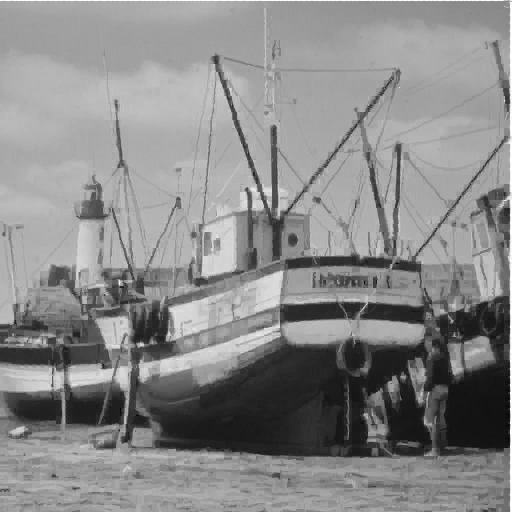

In [5]:
# Decode and display compressed image
decodedimg = decoder(encodedimg)
fimg1 = colorview(Gray, decodedimg)

In [6]:
## Plot distribution of fractal transform parameters
a = []
b = []
c = []
for i = 1:length(encodedimg[1])
    push!(a,encodedimg[1][i][3])
    push!(b,encodedimg[1][i][4])
    push!(c,encodedimg[1][i][5])
end
h = plt[:figure]("", figsize=(6,20))
plt[:subplot](3,1,1)
plt[:hist](a,100)
plt[:xlabel]("alpha")
plt[:ylabel]("Number of blocks")
plt[:title]("$testfile : distribution of alpha values (greyscale scale)")

plt[:subplot](3,1,2)
plt[:hist](b,100)
plt[:xlabel]("beta")
plt[:ylabel]("Number of blocks")
plt[:title]("$testfile : distribution of beta values (greyscale shift)")

plt[:subplot](3,1,3)
plt[:hist](c,8)
plt[:xlabel]("transformation k")
plt[:ylabel]("Number of blocks")
plt[:title]("$testfile : distribution of k indices (transformations)")

LoadError: InterruptException:

In [10]:
# Continuous evolution of fractal transform T
# u_t = Tu - u
# Using simple forward Euler scheme
function continuousevol(encdata)
    tic()
    encoded, numy, numx = encdata
    f = zeros(Int(numy*8),Int(numx*8))
    h = 1e-2
    tol = 1e-7; err = 1
    t = 0; Tend = 10
    count = 0
    while (err < tol) & (t < Tend)
        count = count+1
#         t = t+h
        f,g = fractaltransform(f, encdata)
        f = h*(f-g)+g # First order approximation of evolution equation
        err = f-g
        err = sqrt(sum(err.^2)/length(err))
        tlabel = lpad(string(count),6,"0")
        save("temp/contevol/$tlabel.jpg", map(clamp01nan, colorview(Gray,f)))
    end
    toc()
    return f
end

# Approximate double derivative of image
function approxlaplace(g)
    s = size(g)
    deltaxy = 1/s[1]
    glx = circshift(g, [0 1])
    glx[:,1] = g[:,1]
    grx = circshift(g, [0 -1])
    grx[:,end] = g[:,end]
    gxx = glx - 2g + grx
    gly = circshift(g, [1 0])
    gly[1,:] = g[1,:]
    gry = circshift(g, [-1 0])
    gry[end,:] = g[end,:]
    gyy = gly - 2g + gry
    #     Central differences to approx second derivative
    laplg = zeros(s)
    laplg = gxx + gyy
#     laplg = laplg./deltaxy
#     #     Return gradient magnitude
#     maggradg = zeros(s)
#     #     Central differences to approx first derivative
#     gx = (glx - grx)./(2deltaxy)
#     gy = (gly - gry)./(2deltaxy)
#     maggradg[2:end-1,2:end-1] = sqrt(gx[2:end-1,2:end-1].^2 + gy[2:end-1,2:end-1].^2)    
    return laplg
end

# Continuous evolution of fractal transform T with diffusion term
# u_t = laplace(u) + Tu - u
# Forward time, central in space on [0,1]x[0,1]
function contdiffevol(encdata, diff)
    tic()
    encoded, numy, numx = encdata
    f = zeros(Int(numy*8),Int(numx*8))
#     diff = 1 # Isotropic diffusion term
    #     h = 0.5(1/first(size(f)))^2
    h = 1e-2
    t = 0; Tend = 25
    tol = 1e-10; err = 1
    count = 0
    while (err > tol) & (t < Tend)
#         t = t+h
        count = count+1
        f,g = fractaltransform(f, encdata)
        laplg = approxlaplace(g)
        f = h*(diff*laplg + f - g) + g #Forward Euler scheme
        err = f-g
        err = sqrt(sum(err.^2)/length(err))
        tlabel = lpad(string(count),6,"0")
        save("temp/diffusion/$tlabel.jpg", map(clamp01nan, colorview(Gray,f)))
    end
    toc()
    println(count)
    return f
end

# contimg = continuousevol(encodedimg)
contdiffimg = contdiffevol(encodedimg, 9)
# fimg2 = colorview(Gray, contdiffimg)

elapsed time: 349.85494688 seconds
2358


512×512 Array{Float64,2}:
 0.735228  0.735271  0.735476  0.736108  …  0.729346  0.755066  0.771197
 0.726704  0.726756  0.727     0.727675     0.727198  0.753488  0.770077
 0.71357   0.713678  0.714017  0.714775     0.725658  0.753123  0.770564
 0.69949   0.699674  0.700124  0.700969     0.72576   0.754306  0.772532
 0.686349  0.686598  0.687138  0.688041     0.727469  0.756596  0.775265
 0.674835  0.67512   0.675703  0.676622  …  0.729495  0.759082  0.778014
 0.664829  0.665122  0.665707  0.666601     0.730407  0.760415  0.779566
 0.655819  0.656099  0.656652  0.657485     0.728426  0.758817  0.778234
 0.647121  0.647367  0.647856  0.648588     0.720927  0.751603  0.771543
 0.640805  0.641024  0.64146   0.64211      0.716563  0.747447  0.767575
 0.636192  0.636385  0.636772  0.637349  …  0.714322  0.745325  0.76551 
 0.632775  0.632945  0.633283  0.633788     0.713513  0.744575  0.764758
 0.630169  0.630317  0.63061   0.631042     0.713552  0.744633  0.764762
 ⋮                       

In [34]:
for d in [1]
    f = contdiffevol(encodedimg, d) 
end

elapsed time: 650.205007207 seconds
3414


In [1]:
pwd()

"/Users/martinpham/Desktop/AM495/encoder"

In [5]:
using FileIO
a = load("../../JeffT1.tiff")

190×173×129 Array{Gray{N0f8},3}:
[:, :, 1] =
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)  …  Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)  …  Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)  …  Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 Gray{N0f8}(0.0)  Gray{N0f8}(0.0)     Gray{N0f8}(0.0)  Gray{N0f8}(0.0)
 ⋮                              